In [227]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from tqdm import tqdm

import numpy as np
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt

In [228]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [247]:
def generate_data(size, feature_size=1):
    
    np.random.seed(9)

    # Generate random data points between 0 and 1
    X = np.random.normal(loc = 0, scale=1, size = (size, feature_size))
    # Generate dependent variable by adding random normal noise to X
    y = X*2 + 3
    
    return X, y



def scale(X, y=None, X_max=None, y_max=None, fit=True):
    if fit:
        X_max = np.max(X, axis = 0)
        y_max = np.max(y, axis = 0)
        
        X = X/X_max
        y = y/y_max
        
        return X, y, X_max, y_max
    
    elif y is not None:
        return X/X_max, y/y_max
    else:
        return X/X_max

    
    

In [248]:
X_all, y_all = generate_data(size=5000)


from sklearn.model_selection import train_test_split
train_X,  test_X, train_y, test_y = train_test_split(X_all, y_all, test_size=0.2, 
                                                    shuffle=True, random_state=9)
print(train_X.shape, train_y.shape, test_X.shape,  test_y.shape)

train_X,  train_y, max_X, max_y = scale(train_X,train_y, fit=True)
test_X, test_y = scale(test_X, test_y, X_max = max_X, y_max = max_y, fit=False)

(4000, 1) (4000, 1) (1000, 1) (1000, 1)


In [249]:
train_X_t = torch.from_numpy(train_X)
train_y_t = torch.from_numpy(train_y)

test_X_t = torch.from_numpy(test_X)
test_y_t = torch.from_numpy(test_y)

In [250]:
# Tensors need to have same length in the first axis. Dataset based on idx. 

In [251]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(train_X_t, train_y_t)
test_dataset = TensorDataset(test_X_t, test_y_t)

In [252]:
from torch.utils.data import DataLoader
train_dl = DataLoader(dataset=train_dataset,
                    batch_size = 32,
                    shuffle = True,
                    num_workers = 1
                    )
test_dl =  DataLoader(dataset=test_dataset,
                        batch_size = test_X.shape[0],
                        shuffle = True,
                        num_workers = 1
                        )

In [253]:
HIDDEN_UNITS = 32

In [254]:
# 1. Model Architecture - Using Sequential
model = nn.Sequential(nn.Linear(in_features = train_X.shape[1],out_features = 1, bias=True))
model = model.to(device)

In [255]:
def fit(epochs, mini_batch_size, learning_rate, iterations, evaluate=False):
    
   
    # 2. Loss
    criterion = torch.nn.MSELoss(reduction="mean")

    # 3. Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

    for epoch in range(epochs):
        all_loss = 0
        model.train()

        for batch_X, batch_y in train_dl:

             # 1. Forward Propogation
            y_pred = model(batch_X.float())
            # 2. Compute Loss
            loss = criterion(y_pred, batch_y.float())

            # 3. Ensure gradients are all zero
            optimizer.zero_grad()

            # 4. Back Propogate
            loss.backward()

            #5. Update weights
            optimizer.step()

            all_loss+=loss.item()

        train_epoch_loss = all_loss/(len(train_dl))
        if epoch%10 == 0:
            print("epoch : {}\tloss : {}".format(epoch, train_epoch_loss), end = "\t")
            model.eval()

            if evaluate:
                for test_X, test_y in test_dl:
                    test_y_pred = model(test_X.float())
                    test_loss = criterion(test_y_pred, test_y.float())
                    print("test loss : {}".format(test_loss))

    return model

In [256]:
fitted_model = fit(epochs = 100, 
                    mini_batch_size=32, 
                    learning_rate = 1e-3, 
                    iterations = train_X.shape[0]/32, 
                    evaluate=True)

epoch : 0	loss : 0.07004068422317505	test loss : 0.05388103425502777
epoch : 10	loss : 0.0004734717849642038	test loss : 0.000366208580089733
epoch : 20	loss : 5.972724888124503e-06	test loss : 5.20948651683284e-06
epoch : 30	loss : 2.044203156401636e-06	test loss : 1.949961188074667e-06
epoch : 40	loss : 1.4470370092567465e-06	test loss : 1.3788505839329446e-06
epoch : 50	loss : 1.0351954056204705e-06	test loss : 9.861693115453818e-07
epoch : 60	loss : 7.403888093904243e-07	test loss : 7.05295519765059e-07
epoch : 70	loss : 5.296073491081188e-07	test loss : 5.044005888521497e-07
epoch : 80	loss : 3.786726465477841e-07	test loss : 3.607381131587317e-07
epoch : 90	loss : 2.709106927341054e-07	test loss : 2.580179909728031e-07


# Get Predictions

In [257]:
train_y_pred = fitted_model(train_X_t.float()).detach().numpy()
test_y_pred = fitted_model(test_X_t.float()).detach().numpy()

In [258]:
def plot_predictions(features, y_true, y_pred, title):
    sort_index = np.argsort(y_true, axis = 0)
    plt.scatter(features[sort_index], y_true[sort_index])

    plt.scatter(features[sort_index], y_pred[sort_index])
    plt.title(title)

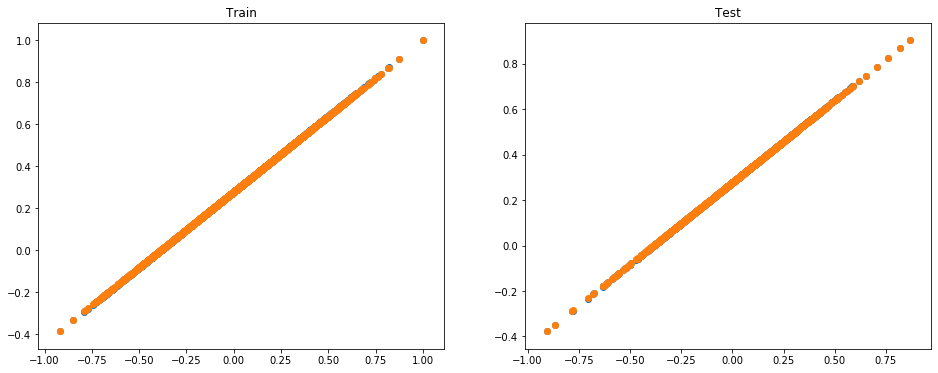

In [259]:
fig = plt.figure(figsize = (16, 6))
fig.add_subplot(121)
plot_predictions(train_X, train_y, train_y_pred, title = "Train")
fig.add_subplot(122)
plot_predictions(test_X, test_y, test_y_pred, title = "Test")

In [260]:
from sklearn.metrics import r2_score

In [261]:
def get_metrics(features, target):
    from sklearn.metrics import r2_score
    prediction = predict(features, scaled=True)
    r2 = r2_score(target, prediction)
    print("R2 Score: {}".format(r2))

In [262]:
print("Train R2 Score : {}".format(r2_score(train_y, train_y_pred)))
print(" Test R2 Score : {}".format(r2_score(test_y, test_y_pred)))


Train R2 Score : 0.9999943751202948
 Test R2 Score : 0.9999943728611114


# Accessing weights of the model

In [263]:
params = dict()
for name, param in fitted_model.named_parameters():
    params[name] = param.detach().numpy()

In [264]:
params

{'0.weight': array([[0.7210454]], dtype=float32),
 '0.bias': array([0.2772436], dtype=float32)}